### If you are Wanting to test it out for yourself, please run every code box until you reach the hyperparamter tuning boxes
- From there, you will want to run the training code boxes and then find the testing code boxes after the training is complete
- For testing, you Should see something like this:
  - RNN_with_LSTM_model Testing
  - test_prompt = 'rick: kill summer <COMMA> morty <EXCLAMATIONMARK>'
  - print(RNN_with_LSTM_model.test(test_prompt, 1000))
- Change the test_prompt string to your desired prompt and the integer to however many characters you want the model to generate

### WARNING

- These models do not like working with unknown words from its vocabulary, so it will perform extremely poorly if you use something outside of its vocabulary.
  - Refer to the AllScripts.txt as any words in there will work just fine
- On top of this, you will want to replace punctuation with this list:
  - . $~~~~$|$~~~$<PERIOD\>
  - , $~~~~$|$~~~$<COMMA\>
  - " $~~~$|$~~~$<QUOTATIONMARK\>
  - ? $~~~$|$~~~$<QUESTIONMARK\>
  - \- $~~~$|$~~~$<DASH\>
  - \n $~$|$~~~$<RETURN\>
  - ) $~~~$|$~~~$<RIGHTPARENTHESES\>
  - ( $~~~$|$~~~$<LEFTPARENTHESES\>
  - [ $~~~$|$~~~$<LEFTBRACKET\>
  - ] $~~~$|$~~~$<RIGHTBRACKET\>
  - ; $~~~$|$~~~$<SEMICOLON\>
  - ! $~~~$|$~~~$<EXCLAMATIONMARK\>

### Needed to Run Properly (and all in the same directory)
1. AllScripts.txt
2. Folder named 'dataset'
3. Any imports that you do not already have installed

In [37]:
# Imports
import argparse
from collections import Counter
import itertools
import math
import matplotlib.pyplot as plt
from nltk.tokenize import regexp_tokenize
import numpy as np
import os
import pandas as pd
import pickle
import re
import torch
from torch import nn, optim
from torch.utils.data import DataLoader

In [39]:
# Preprocessing
def load_words(file_path):
    input_file = os.path.join(file_path)
    with open(input_file, "r", encoding="utf-8") as f:
        data = f.read()

    return clean_text(data)

def get_uniq_words(words):
    word_counts = Counter(words)
    return sorted(word_counts, key=word_counts.get, reverse=True)

# This will probably need to be tinkered with
def custom_tokenizer(text):
    pattern = r'''(?x)                      # set flag to allow verbose regexps
                  (?:[A-Z]\.)+              # abbreviations, e.g. U.S.A.
                  |\w+:                      # names followed by colons
                  |\w+(?:[-']\w+)*          # words with optional internal hyphens/apostrophes
                  |\$?\d+(?:\.\d+)?         # currency/numbers, e.g. $12.80
                  |[.,?!'";]                # punctuation
                  |\[|\]                    # left and right brackets
                  |\(|\)                    # left and right parentheses
                '''
    return regexp_tokenize(text, pattern)

def clean_text(text):
    # reference on how to get the proper dependencies
    # https://machinelearningmastery.com/clean-text-machine-learning-python/
    punct={
        '.':"<PERIOD>",
        ",":"<COMMA>",
        '"':"<QUOTATIONMARK>",
        "?":"<QUESTIONMARK>",
        "-":"<DASH>",
        "\n":"<RETURN>",
        ")":"<RIGHTPARENTHESES>",
        "(":"<LEFTPARENTHESES>",
        "[":"<LEFTBRACKET>",
        "]":"<RIGHTBRACKET>",
        ";":"<SEMICOLON>",
        "!":"<EXCLAMATIONMARK>"
    }

    tokens = custom_tokenizer(text)
    # convert to lowercase
    tokens = [w.lower() for w in tokens]

    # replace punctuation
    for key, token in punct.items():
      tokens = [w.replace(key, '{}'.format(token)) for w in tokens]

    return tokens

words = load_words('./AllScripts.txt')
unique = get_uniq_words(words)
valid_unique = get_uniq_words(valid_words)
unique.append('<UNK>')
unique.append('<PAD>')

index_to_word = {index: word for index, word in enumerate(unique)}
word_to_index = {word: index for index, word in enumerate(unique)}
words_index = [word_to_index[w] for w in words]

folder = './dataset'
with open(folder + '/clean_data.pickle', 'wb') as file:
    pickle.dump(words, file, protocol=pickle.HIGHEST_PROTOCOL)

with open(folder + '/index_to_word.pickle', 'wb') as file:
    pickle.dump(index_to_word, file, protocol=pickle.HIGHEST_PROTOCOL)

with open(folder + '/word_to_index.pickle', 'wb') as file:
    pickle.dump(word_to_index, file, protocol=pickle.HIGHEST_PROTOCOL)

with open(folder + '/words_index.pickle', 'wb') as file:
    pickle.dump(words_index, file, protocol=pickle.HIGHEST_PROTOCOL)

with open(folder + '/unique_words.pickle', 'wb') as file:
    pickle.dump(unique, file, protocol=pickle.HIGHEST_PROTOCOL)

In [45]:
class Dataset_Loader():
    data = None
    dataset_source_folder_path = None
    dataset_source_name = None

    def __init__(self, dSrcPath=None, dName=None):
        self.dataset_source_folder_path = dSrcPath
        self.dataset_source_name = dName

    def load(self):
        print('loading data...')

        index_to_word = None
        word_to_index = None

        # Training Dataset
        with open(self.dataset_source_folder_path + self.dataset_source_name + 'clean_data.pickle', 'rb') as file:
            dataset = pickle.load(file)

        with open(self.dataset_source_folder_path + self.dataset_source_name + 'index_to_word.pickle', 'rb') as file:
            index_to_word = pickle.load(file)

        with open(self.dataset_source_folder_path + self.dataset_source_name + 'word_to_index.pickle', 'rb') as file:
            word_to_index = pickle.load(file)

        with open(self.dataset_source_folder_path + self.dataset_source_name + 'words_index.pickle', 'rb') as file:
            words_index = pickle.load(file)

        with open(self.dataset_source_folder_path + self.dataset_source_name + 'unique_words.pickle', 'rb') as file:
            unique = pickle.load(file)

        self.data = {
            'train': dataset,
            'index_to_word': index_to_word,
            'word_to_index': word_to_index,
            'words_index': words_index,
            'unique': unique
        }

In [46]:
class GenerationDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        word_window,
        data
    ):
        self.word_window = word_window
        self.index_to_word = data['index_to_word']
        self.word_to_index = data['word_to_index']
        self.words_index = data['words_index']

    def __len__(self):
        return len(self.words_index) - self.word_window

    def __getitem__(self, idx):
        return (
            torch.tensor(self.words_index[idx:idx+self.word_window]),
            torch.tensor(self.words_index[idx+1:idx+self.word_window+1]),
        )

In [47]:
# RNN
class Method_RNN_Generation(nn.Module):
    data = None
    dataset = None
    train_data = None

    max_epoch = 20
    learning_rate = 1e-2
    size = 128
    num_layers = 2
    batch_size = 512
    word_window = 12
    dropout = 0.15

    def __init__(self, data):
        super(Method_RNN_Generation, self).__init__()
        self.data = data
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.initialize_layers()

    def initialize_layers(self):
        num_words = len(self.data['unique'])
        self.embedding = nn.Embedding(num_embeddings=num_words, embedding_dim=self.size)
        self.rnn = nn.RNN(
            input_size=self.size,
            hidden_size=self.size,
            num_layers=self.num_layers,
            dropout=self.dropout,
            batch_first=True,
        )
        self.fc = nn.Linear(self.size, num_words)
        self.dropout_layer = nn.Dropout(self.dropout)
        self.to(self.device)

    def initial_state(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.size).to(self.device)

    def forward(self, x, previous):
        embed = self.embedding(x)
        embed = self.dropout_layer(embed)
        out, current = self.rnn(embed, previous)
        out = self.fc(out)
        return out, current

    def train(self):
        print('--start training...')
        optimizer = optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=1e-5)
        loss_function = nn.CrossEntropyLoss()
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

        training_accuracies = []
        training_loss = []
        training_perplexity = []

        for epoch in range(self.max_epoch):
            total_loss = 0.0
            total_words = 0

            for batch, (inputs, labels) in enumerate(self.train_data):
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                optimizer.zero_grad()

                batch_size = inputs.size(0)
                h0 = self.initial_state(batch_size)

                y_pred, h0 = self.forward(inputs, h0)
                loss = loss_function(y_pred.transpose(1, 2), labels)

                total_loss += loss.item() * batch_size
                total_words += labels.numel()

                h0 = h0.detach()

                loss.backward()
                nn.utils.clip_grad_norm_(self.parameters(), max_norm=5)
                optimizer.step()

                if batch == 0:
                    _, predicted = torch.max(y_pred.data, 2)
                    total = labels.size(0) * labels.size(1)
                    correct = (predicted == labels).sum().item()
                    accuracy = correct / total

                    epoch_loss = total_loss / total_words
                    perplexity = math.exp(epoch_loss)

                    print(f'[{epoch}, {batch}] loss: {loss.item()} accuracy: {accuracy} perplexity: {perplexity}')
                    training_accuracies.append(accuracy)
                    training_loss.append(loss.item())
                    training_perplexity.append(perplexity)
                    
            scheduler.step()

        return training_accuracies, training_loss, training_perplexity

    def test(self, text, next_words=12):
        print('--start testing...')
        words = text.split(' ')
        fixed_words = [word if word in word_to_index else '<UNK>' for word in words]
        print(fixed_words)
        h0 = self.initial_state(1)

        for _ in range(next_words):
            x = torch.tensor([[self.dataset.word_to_index[w] for w in fixed_words]]).to(self.device)
            y_pred, h0 = self.forward(x, h0)

            last_word_outputs = y_pred[0][-1]
            p = torch.nn.functional.softmax(last_word_outputs.cpu(), dim=0).detach().numpy()
            word_index = np.random.choice(len(last_word_outputs), p=p)
            words.append(self.dataset.index_to_word[word_index])

        return self.decipher(words)

    def decipher(self, words):
        punct = {
            '.': "<PERIOD>",
            ",": "<COMMA>",
            '"': "<QUOTATIONMARK>",
            "?": "<QUESTIONMARK>",
            "-": "<DASH>",
            "\n": "<RETURN>",
            ")": "<RIGHTPARENTHESES>",
            "(": "<LEFTPARENTHESES>",
            "[": "<LEFTBRACKET>",
            "]": "<RIGHTBRACKET>",
            ";": "<SEMICOLON>",
            "!": "<EXCLAMATIONMARK>"
        }

        script = ''
        for word in words:
            if '<' in word:
                for pun, replacement in punct.items():
                    if word == replacement:
                        if word == '<LEFTBRACKET>':
                            script += '\n\n'
                        elif 'BRACKET' in word or 'PARENTHESES' in word:
                            script += ' '
                        word = pun
                    elif replacement in word:
                        word = word.replace(replacement, pun)
                        script += ' '
                script += word
            elif ':' in word or word == '[':
                script += '\n\n' + word
            else:
                script += ' ' + word
        return script

    def grid_search(self, hyperparameters):
        best_loss = math.inf
        best_hyperparameters = None

        for params in itertools.product(*hyperparameters.values()):
            print(params)
            self.learning_rate, self.size, self.num_layers, self.batch_size, self.word_window, self.dropout = params
            self.rnn = nn.RNN(
                input_size=self.size,
                hidden_size=self.size,
                num_layers=self.num_layers,
                dropout=self.dropout,
                batch_first=True,
            )
            self.initialize_layers()
            self.dataset = GenerationDataset(self.word_window, self.data)
            self.train_data = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True)
            _, losses, _ = self.train()
            loss = sum(losses) / len(losses)

            if loss < best_loss:
                best_loss = loss
                best_hyperparameters = params

        return best_hyperparameters

    def setup(self):
        print('method running...')
        self.initialize_layers()
        self.dataset = GenerationDataset(self.word_window, self.data)
        self.train_data = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True)

In [48]:
class Method_RNN_Generation_LSTM(nn.Module):
    data = None
    dataset = None
    train_data = None

    max_epoch = 20
    learning_rate = 1e-2
    size = 256
    num_layers = 2
    batch_size = 512
    word_window = 14
    dropout = 0.1

    def __init__(self, data):
        super(Method_RNN_Generation_LSTM, self).__init__()
        self.data = data
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.initialize_layers()

    def initialize_layers(self):
        num_words = len(self.data['unique'])
        self.embedding = nn.Embedding(num_embeddings=num_words, embedding_dim=self.size)
        self.rnn = nn.LSTM(input_size=self.size, hidden_size=self.size, num_layers=self.num_layers,
                           dropout=self.dropout, batch_first=True)
        self.fc = nn.Linear(self.size, num_words)
        self.to(self.device)

    def initial_state(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.size).to(self.device),
                torch.zeros(self.num_layers, batch_size, self.size).to(self.device))

    def forward(self, x, previous):
        embed = self.embedding(x)
        out, current = self.rnn(embed, previous)
        out = self.fc(out)
        return out, current

    def train(self):
        print('--start training...')
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        loss_function = nn.CrossEntropyLoss()

        training_accuracies = []
        training_loss = []
        training_perplexity = []

        for epoch in range(self.max_epoch):
            total_loss = 0.0
            total_words = 0

            for batch, (inputs, labels) in enumerate(self.train_data):
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                optimizer.zero_grad()

                batch_size = inputs.size(0)
                h0, c0 = self.initial_state(batch_size)

                y_pred, (h0, c0) = self.forward(inputs, (h0, c0))
                loss = loss_function(y_pred.transpose(1, 2), labels)

                total_loss += loss.item() * batch_size
                total_words += labels.numel()

                loss.backward()
                optimizer.step()

                if batch == 0:
                    _, predicted = torch.max(y_pred.data, 2)
                    total = labels.size(0) * labels.size(1)
                    correct = (predicted == labels).sum().item()
                    accuracy = correct / total

                    epoch_loss = total_loss / total_words
                    perplexity = math.exp(epoch_loss)

                    print(f'[{epoch}, {batch}] loss: {loss.item()} accuracy: {accuracy} perplexity: {perplexity}')
                    training_accuracies.append(accuracy)
                    training_loss.append(loss.item())
                    training_perplexity.append(perplexity)

        return training_accuracies, training_loss, training_perplexity

    def grid_search(self, hyperparameters):
        best_loss = math.inf
        best_hyperparameters = None

        for params in itertools.product(*hyperparameters.values()):
            print(params)
            self.learning_rate, self.size, self.num_layers, self.batch_size, self.word_window, self.dropout = params
            self.rnn = nn.LSTM(input_size=self.size, hidden_size=self.size, num_layers=self.num_layers,
                               dropout=self.dropout, batch_first=True)
            self.initialize_layers()
            self.dataset = GenerationDataset(self.word_window, self.data)
            self.train_data = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True)
            _, losses, _ = self.train()
            loss = sum(losses) / len(losses)

            if loss < best_loss:
                best_loss = loss
                best_hyperparameters = params

        return best_hyperparameters

    def test(self, text, next_words=100):
        print('--start testing...')
        words = text.split(' ')
        h0, c0 = self.initial_state(1)

        for i in range(next_words):
            x = torch.tensor([[self.dataset.word_to_index[w] for w in words[i:]]]).to(self.device)
            y_pred, (h0, c0) = self.forward(x, (h0, c0))

            last_word_outputs = y_pred[0][-1]
            p = torch.nn.functional.softmax(last_word_outputs.cpu(), dim=0).detach().numpy()
            word_index = np.random.choice(len(last_word_outputs), p=p)
            words.append(self.dataset.index_to_word[word_index])

        return self.decipher(words)

    def decipher(self, words):
        punct = {
            '.': "<PERIOD>",
            ",": "<COMMA>",
            '"': "<QUOTATIONMARK>",
            "?": "<QUESTIONMARK>",
            "-": "<DASH>",
            "\n": "<RETURN>",
            ")": "<RIGHTPARENTHESES>",
            "(": "<LEFTPARENTHESES>",
            "[": "<LEFTBRACKET>",
            "]": "<RIGHTBRACKET>",
            ";": "<SEMICOLON>",
            "!": "<EXCLAMATIONMARK>"
        }

        script = ''
        for word in words:
            if '<' in word:
                for pun, replacement in punct.items():
                    if word == replacement:
                        if word == '<LEFTBRACKET>':
                            script += '\n\n'
                        elif 'BRACKET' in word or 'PARENTHESES' in word:
                            script += ' '
                        word = pun
                    elif replacement in word:
                        word = word.replace(replacement, pun)
                        script += ' '
                script += word
            elif ':' in word or word == '[':
                script += '\n\n' + word
            else:
                script += ' ' + word
        return script

    def setup(self):
        print('method running...')
        self.initialize_layers()
        self.dataset = GenerationDataset(self.word_window, self.data)
        self.train_data = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True)

In [57]:
# Setup Models
dataset_source_folder_path = './'
dataset_source_name = 'dataset/'
dataset = Dataset_Loader(dataset_source_folder_path, dataset_source_name)
dataset.load()
print(dataset.data)

RNN_model = Method_RNN_Generation(dataset.data)
RNN_model.setup()

RNN_with_LSTM_model = Method_RNN_Generation_LSTM(dataset.data)
RNN_with_LSTM_model.setup()

loading data...
{'train': ['<LEFTBRACKET>', 'episode', 'begins', 'in', 'morty', 's', 'room', 'where', 'he', 'is', 'sleeping', 'in', 'his', 'bed', '<RIGHTBRACKET>', 'rick:', '<LEFTPARENTHESES>', 'stumbles', 'in', 'drunkenly', '<COMMA>', 'and', 'turns', 'on', 'the', 'lights', '<RIGHTPARENTHESES>', 'morty', '<EXCLAMATIONMARK>', 'you', 'gotta', 'come', 'on', '<PERIOD>', 'you', 'got', '<PERIOD>', '<PERIOD>', '<PERIOD>', 'you', 'gotta', 'come', 'with', 'me', '<PERIOD>', 'morty:', '<LEFTPARENTHESES>', 'rubs', 'his', 'eyes', '<RIGHTPARENTHESES>', 'what', '<COMMA>', 'rick', '<QUESTIONMARK>', 'what', 's', 'going', 'on', '<QUESTIONMARK>', 'rick:', 'i', 'got', 'a', 'surprise', 'for', 'you', '<COMMA>', 'morty', '<PERIOD>', 'morty:', "it's", 'the', 'middle', 'of', 'the', 'night', '<PERIOD>', 'what', 'are', 'you', 'talking', 'about', '<QUESTIONMARK>', 'rick:', '<LEFTPARENTHESES>', 'spills', 'alcohol', 'on', "morty's", 'bed', '<RIGHTPARENTHESES>', 'come', 'on', '<COMMA>', 'i', 'got', 'a', 'surprise', 

In [50]:
# Hyperparameter Tuning
# Learning Rates = [1e-1, 1e-2, 1e-3, 1e-4]
# size = [32, 64, 128, 256, 512]
# num_layers = [2, 3, 4]
# batch_size = [32, 64, 128, 256, 512]
# word_window = [2, 4, 6, 8, 10, 12, 14, 16]

hyperparameters = {
    'learning_rate': [1e-2],
    'size': [128],
    'num_layers': [2],
    'batch_size': [256, 512],
    'word_window': [12],
    'dropout': [0.1, 0.15]
}

# Best: (0.01, 128, 2, 256, 12, 0.1)
best_hyperparameters = RNN_model.grid_search(hyperparameters)

print(best_hyperparameters)

(0.01, 128, 2, 256, 12, 0.1)
--start training...
[0, 0] loss: 8.552712440490723 accuracy: 0.0003255208333333333 perplexity: 2.039543557928116
[1, 0] loss: 3.577054977416992 accuracy: 0.2718098958333333 perplexity: 1.3472802285244236


KeyboardInterrupt: 

--start training...
[0, 0] loss: 8.556965827941895 accuracy: 0.00016276041666666666 perplexity: 2.0402666001426084
[1, 0] loss: 4.103326320648193 accuracy: 0.21500651041666666 perplexity: 1.407681268145415
[2, 0] loss: 3.3184592723846436 accuracy: 0.2978515625 perplexity: 1.318557416502807
[3, 0] loss: 3.0043210983276367 accuracy: 0.3406575520833333 perplexity: 1.2844878666182864
[4, 0] loss: 2.8261709213256836 accuracy: 0.36279296875 perplexity: 1.2655594070531335
[5, 0] loss: 2.663660764694214 accuracy: 0.3914388020833333 perplexity: 1.2485360817387592
[6, 0] loss: 2.5793519020080566 accuracy: 0.4012044270833333 perplexity: 1.239794936107152
[7, 0] loss: 2.4962270259857178 accuracy: 0.408203125 perplexity: 1.2312364628844956
[8, 0] loss: 2.4087226390838623 accuracy: 0.4339192708333333 perplexity: 1.2222909021973487
[9, 0] loss: 2.3954951763153076 accuracy: 0.43359375 perplexity: 1.2209443272073701
[10, 0] loss: 2.3282322883605957 accuracy: 0.4501953125 perplexity: 1.2141197848866312


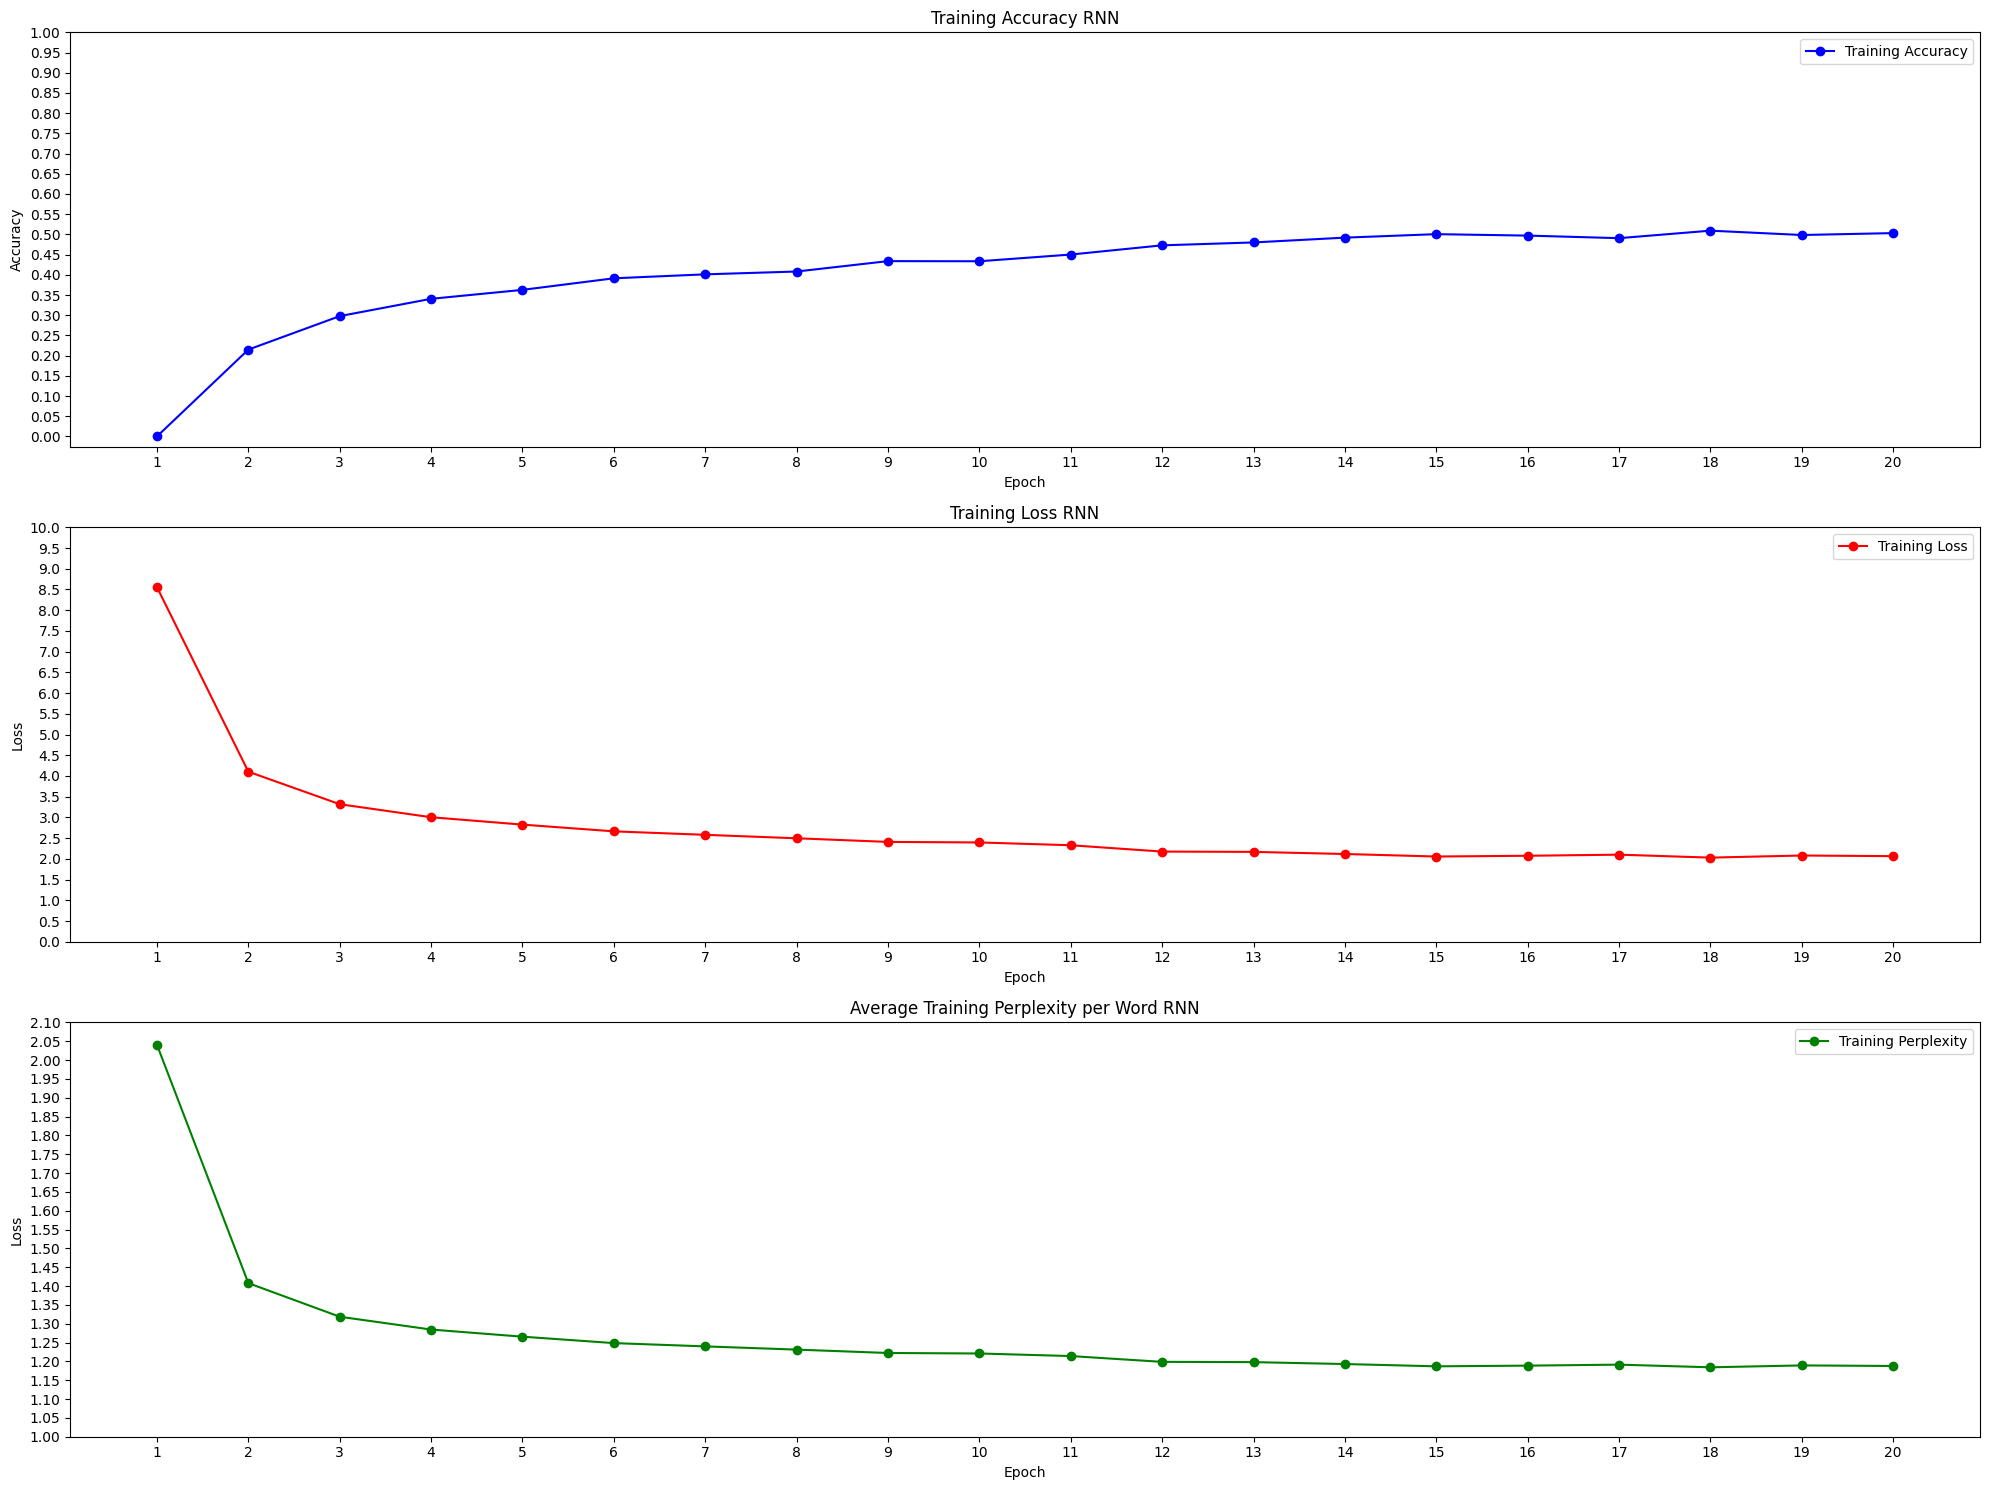

In [58]:
# RNN_model Training
tr_acc, tr_loss, tr_perplexities = RNN_model.train()

plt.figure(figsize=(20, 15))
plt.subplot(3, 1, 1)
plt.title("Training Accuracy RNN")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(range(1, RNN_model.max_epoch + 1, 1), tr_acc, 'o-', color="b", label="Training Accuracy")
plt.legend(loc="best")
plt.xticks(range(1, RNN_model.max_epoch + 1))
plt.yticks([i * 0.05 for i in range(0, 21)])

# Plot for Training Loss
plt.subplot(3, 1, 2)
plt.title("Training Loss RNN")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(range(1, RNN_model.max_epoch + 1, 1), tr_loss, 'o-', color="r", label="Training Loss")
plt.legend(loc="best")
plt.xticks(range(1, RNN_model.max_epoch + 1))
plt.yticks([i * 0.5 for i in range(0, 21)])

# Plot for Training Perplexity
plt.subplot(3, 1, 3)
plt.title("Average Training Perplexity per Word RNN")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(range(1, RNN_model.max_epoch + 1, 1), tr_perplexities, 'o-', color="g", label="Training Perplexity")
plt.legend(loc="best")
plt.xticks(range(1, RNN_model.max_epoch + 1))
plt.yticks([i * 0.05 for i in range(20, 43)])

plt.tight_layout()
plt.show()

In [52]:
# RNN_model Testing
test_prompt = 'rick: mmm panda express'
print(RNN_model.test(test_prompt, 1000))

--start testing...
['rick:', 'mmm', 'panda', 'express']


rick: mmm panda express that with with,,. that with in the, with.. are,,?,..?.,. beating for.,,.. it with?., with, it,, is.,...? the,,,.?. ). this.., that,??? it?.,. the., morty with.. your., women,,?. it,,,.. so the,. and.? with from. s.,?, and that,. with?. the that,. a.?.? with., up? and the.. are..? ), so?!?,., the ) was,. genetically,.. that, inside.. it with with, like,? an,,. inside, up,..? with,. with, stops,?,.,?.,,?, the,., the,.., the.. he's, s.,?... with beating that.?. to,,,.. the. inside with out, s. and,,, very.,,.. is.,.,. to this?? are. from..,.,,,?., you with the with,??. bitch.. that,?, with,.. it with.?.... that,... that. with,,, that. with?,, the with? and?.,,., is. he's this a to the with?,.? it inside,,.., that,,?., crowd?. just. and,,?... the with.,, your that that.., found?... with.,, your. the with ),, this the..,! that, that that,... rick that..,. your, with from, this.,,,?,....?.. ) ) with a.?. your. 

In [54]:
# Hyperparameter Tuning for RNN with LSTM
# Learning Rates = [1e-1, 1e-2, 1e-3, 1e-4]
# size = [32, 64, 128, 256, 512]
# num_layers = [2, 3, 4]
# batch_size = [32, 64, 128, 256, 512]
# word_window = [2, 4, 6, 8, 10, 12, 14, 16]

hyperparameters = {
    'learning_rate': [1e-2, 1e-3],
    'size': [128, 256, 512],
    'num_layers': [2, 3],
    'batch_size': [256, 512],
    'word_window': [10, 12, 14],
    'dropout': [0.1, 0.15, 0.2]
}

# Best: (0.01, 256, 2, 512, 14, 0.1)
best_hyperparameters = RNN_with_LSTM_model.grid_search(hyperparameters)

print(best_hyperparameters)

(0.01, 128, 2, 256, 10, 0.1)
--start training...
[0, 0] loss: 8.530741691589355 accuracy: 0.0 perplexity: 2.3468503888934786


KeyboardInterrupt: 

--start training...
[0, 0] loss: 8.538224220275879 accuracy: 0.0 perplexity: 1.8401979706745832
[1, 0] loss: 4.544886112213135 accuracy: 0.21219308035714285 perplexity: 1.3835251827737953
[2, 0] loss: 3.035069227218628 accuracy: 0.3759765625 perplexity: 1.2420840559093251
[3, 0] loss: 2.069504976272583 accuracy: 0.5472935267857143 perplexity: 1.159306271047725
[4, 0] loss: 1.5910807847976685 accuracy: 0.6340680803571429 perplexity: 1.1203583925693625
[5, 0] loss: 1.366509199142456 accuracy: 0.6788504464285714 perplexity: 1.1025302878548968
[6, 0] loss: 1.136187195777893 accuracy: 0.7308872767857143 perplexity: 1.0845403191897631
[7, 0] loss: 1.0090776681900024 accuracy: 0.7610212053571429 perplexity: 1.074738070239144
[8, 0] loss: 0.913446843624115 accuracy: 0.7819475446428571 perplexity: 1.0674217946073687
[9, 0] loss: 0.8875541090965271 accuracy: 0.7903180803571429 perplexity: 1.065449442714959
[10, 0] loss: 0.8316599726676941 accuracy: 0.8059430803571429 perplexity: 1.06120418164617

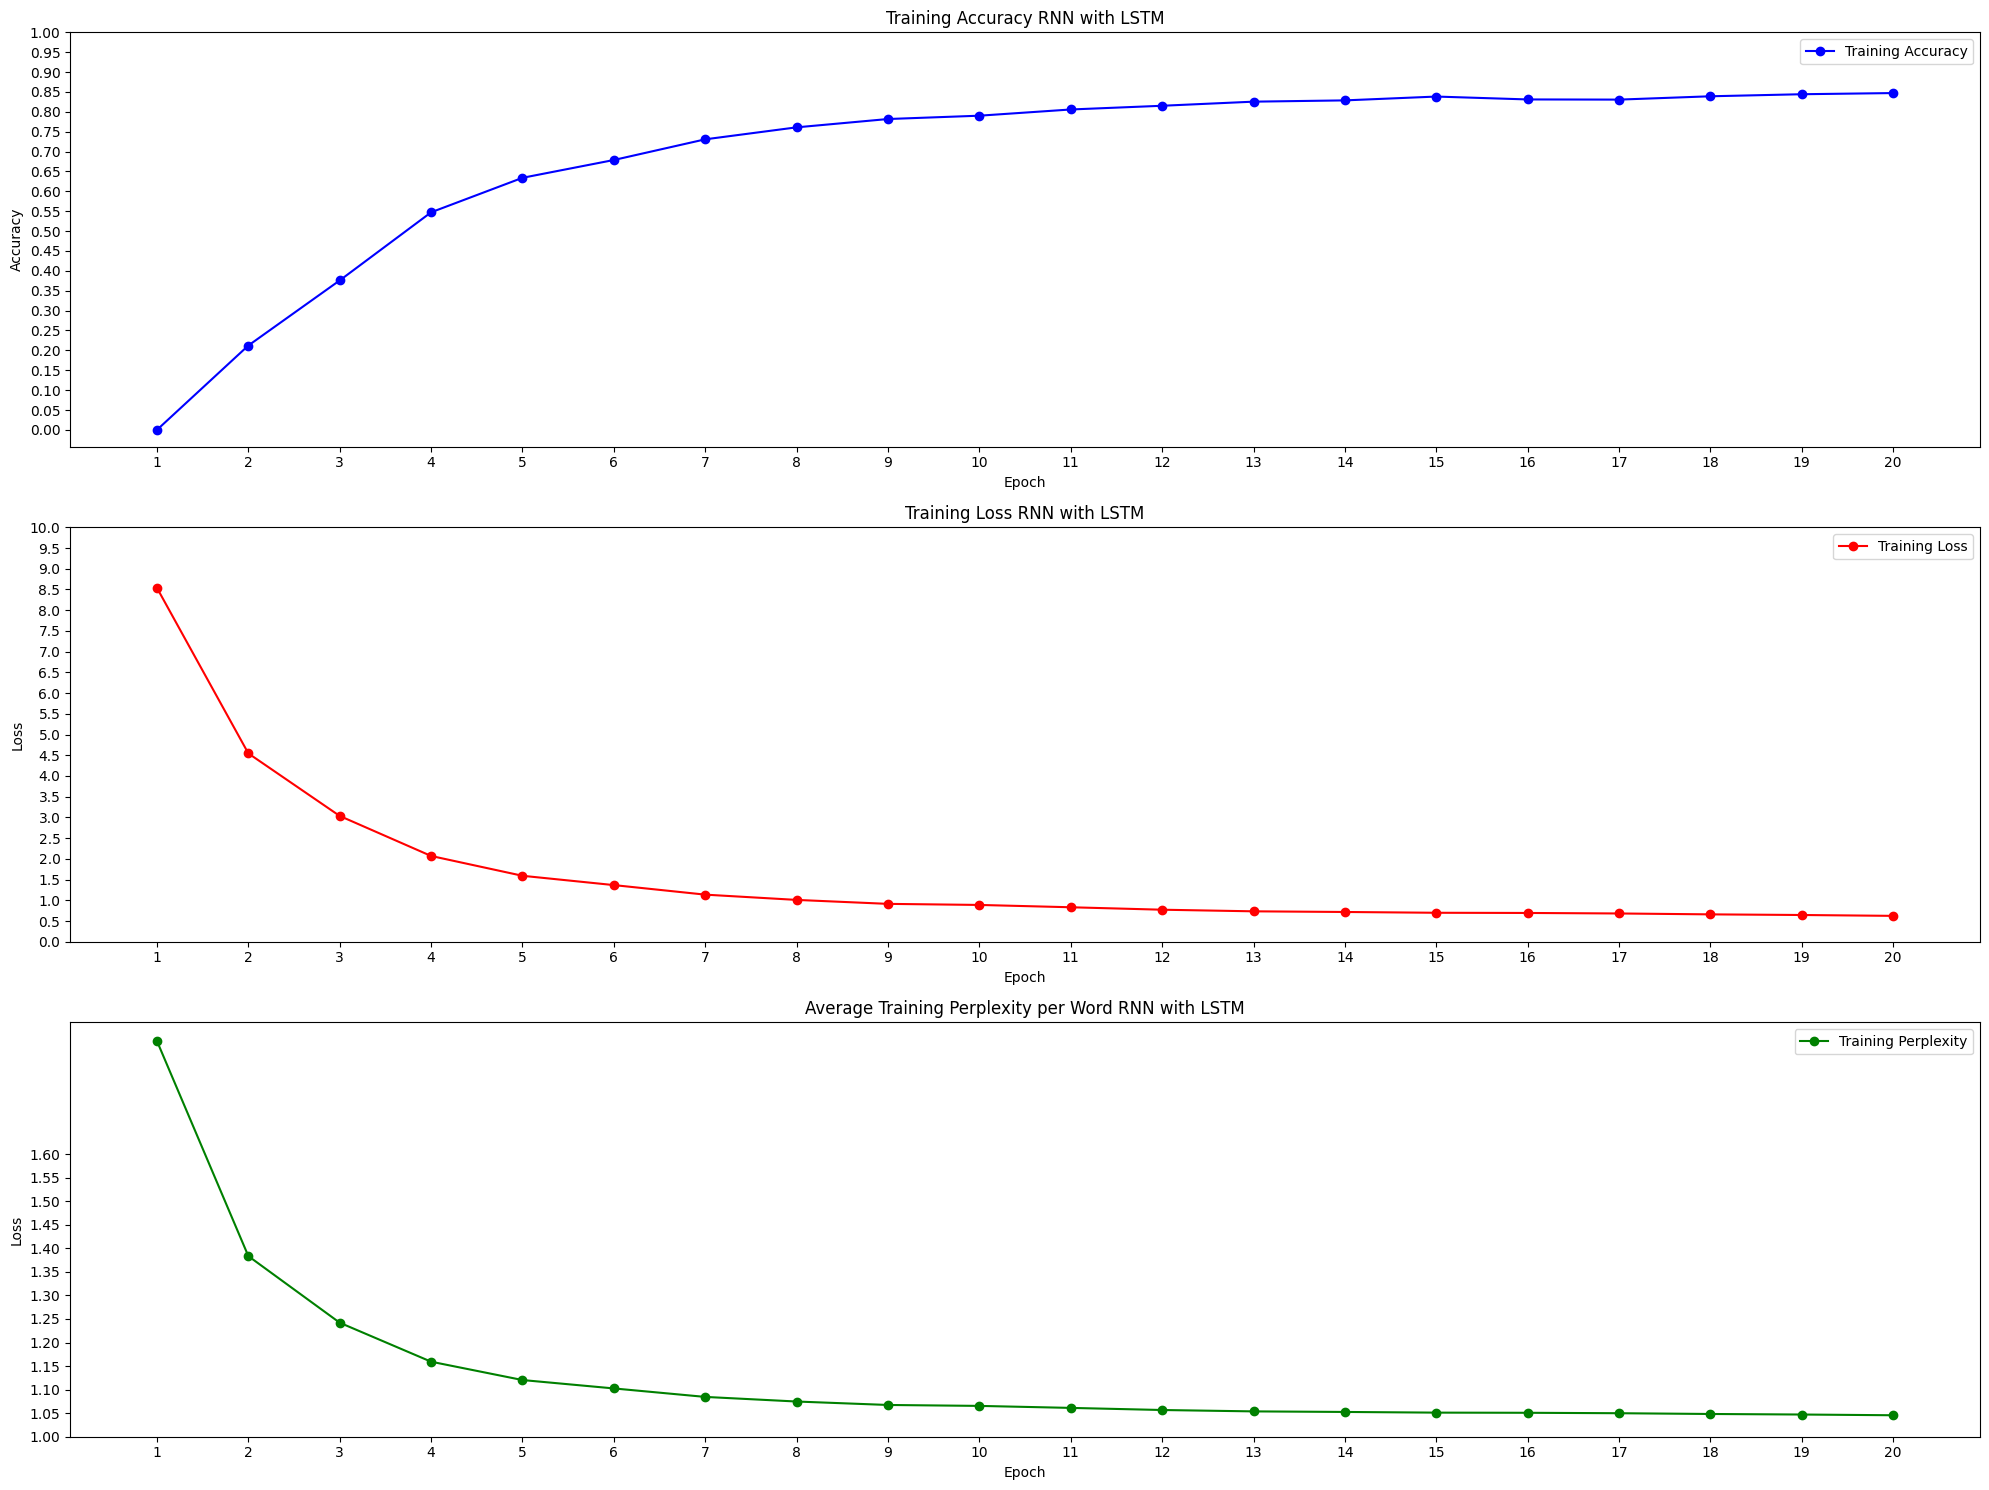

In [59]:
# RNN_with_LSTM_model Training
tr_acc, tr_loss, tr_perplexities = RNN_with_LSTM_model.train()

plt.figure(figsize=(20, 15))
plt.subplot(3, 1, 1)
plt.title("Training Accuracy RNN with LSTM")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(range(1, RNN_with_LSTM_model.max_epoch + 1, 1), tr_acc, 'o-', color="b", label="Training Accuracy")
plt.legend(loc="best")
plt.xticks(range(1, RNN_with_LSTM_model.max_epoch + 1))
plt.yticks([i * 0.05 for i in range(0, 21)])

# Plot for Training Loss
plt.subplot(3, 1, 2)
plt.title("Training Loss RNN with LSTM")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(range(1, RNN_with_LSTM_model.max_epoch + 1, 1), tr_loss, 'o-', color="r", label="Training Loss")
plt.legend(loc="best")
plt.xticks(range(1, RNN_with_LSTM_model.max_epoch + 1))
plt.yticks([i * 0.5 for i in range(0, 21)])

# Plot for Training Perplexity
plt.subplot(3, 1, 3)
plt.title("Average Training Perplexity per Word RNN with LSTM")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(range(1, RNN_with_LSTM_model.max_epoch + 1, 1), tr_perplexities, 'o-', color="g", label="Training Perplexity")
plt.legend(loc="best")
plt.xticks(range(1, RNN_with_LSTM_model.max_epoch + 1))
plt.yticks([i * 0.05 for i in range(20, 33)])

plt.tight_layout()
plt.show()

In [60]:
# RNN_with_LSTM_model Testing
test_prompt = 'rick: kill summer <COMMA> morty <EXCLAMATIONMARK>'
print(RNN_with_LSTM_model.test(test_prompt, 1000))

--start testing...


rick: kill summer, morty! she's still there, and then we get to the large intestine! in every week on! we got to do is gonna be a lot like that, except, i think we got later. oh,

morty: i get those necklaces in? what are you talking about? bothall

ricks: our time is fractured. you two somehow created a feedback loop of uncertainty that's split our hands? all right, that's it. we're just gonna go there, so far, but i'm almost sorry we're finished.

beth: yes, it's satisfying work. unh-unh-unh, ay, ay, the watch him, and then incepts her dream with morty )

rick: too bad about dr. bloom. rick, annie, and

jerry: ( all at once ) narcissism. the narcisstic stuff. i want the fact remains if you impose gazorpazorp's laws on earth, you're just a bunch of cronenbergs! you got to fix this, rick!

rick: then then summer comes by, seeing frank's frozen body ) summer ( in real doors, cluttering up your house, where muscular mannies are coming, and they're also in another dog